# Source reconstruction with lens mass fitting

Runs MCMC over lens model parameters, using SLIT to reconstruct the source at each iteration.

In [1]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap
import corner

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from lenstronomy.LightModel.Profiles.starlets import Starlets

from slitronomy.Util.plot_util import nice_colorbar

from TDLMCpipeline.Util.plots import plot_convergence_by_walker
from TDLMCpipeline.Util.params import model_from_mcmc_sample

%matplotlib inline


lensing_operator = 'interpol'
subgrid_res_source = 1
use_threshold_mask = False
source_type = 'double_sersic'


n_burn = 0
n_run = 10
walker_ratio = 10
num_threads = 8

# uncomment parameters to fix those to truth
mass_fixed_list = [
    #'theta_E',
    #'e1', 'e2',
    #'center_x', 'center_y'
]


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.17.0    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [3]:
# data specifics
num_pix = 69  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 15

(15, 15)


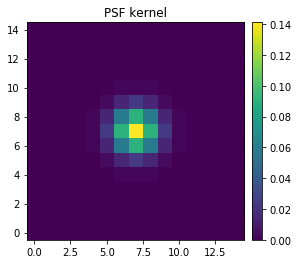

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
no_convolution = False
if no_convolution:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [5]:
lens_model_list = ['SIE']  # SPEMD
#kwargs_spemd = {'gamma': 2, 'theta_E': 1, 'center_x': 0.02, 'center_y': 0.05, 'e1': -0.1, 'e2': 0.1}
kwargs_sie = {'theta_E': 1, 'center_x': 0.02, 'center_y': 0.05, 'e1': -0.1, 'e2': 0.1}
kwargs_lens = [kwargs_sie]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
kwargs_sersic_ellipse_source2 = {'amp': 60, 'R_sersic': 0.4, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                'center_x': 0.2, 'center_y': 0.1}
kwargs_sersic_ellipse_source1 = {'amp': 130, 'R_sersic': 0.4, 'n_sersic': 1, 'e1': -0.02, 'e2': 0.02,
                                'center_x': -0.2, 'center_y': 0.2}
kwargs_source = [kwargs_sersic_ellipse_source1, kwargs_sersic_ellipse_source2]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_truth = {
    'kwargs_lens': kwargs_lens, 
    'kwargs_source': kwargs_source, 
    'kwargs_lens_light': kwargs_lens_light,
    'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
}

In [6]:
kwargs_numerics_sim = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics_sim)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
kwargs_data['noise_map']  = background_rms * np.ones_like(image_sim)
data_class.update_data(image_sim)

In [7]:
# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix, 
                                                      subgrid_res=subgrid_res_source)

# get the light distribution in source plane on high resolution grid
source_sim_1d_hd = source_model_class.surface_brightness(x_grid_src_1d, y_grid_src_1d, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_1d_hd)

# get the light distribution in source plane at the image plane resolution
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

In [8]:
# get an automatic mask that includes the lensed source light
threshold_noise = 5
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold_noise * background_rms)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

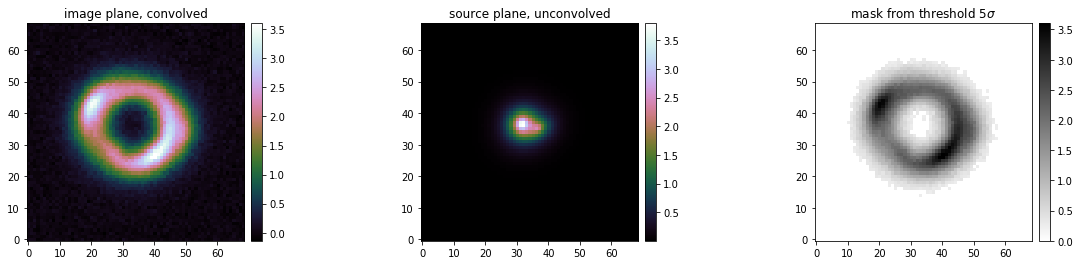

In [9]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("mask from threshold {}$\sigma$".format(threshold_noise))
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 2))
#ax.set_title(r"$\alpha_x$")
#im = ax.imshow(alpha_x, origin='lower', cmap='seismic')
#nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 3))
#ax.set_title(r"$\alpha_y$")
#im = ax.imshow(alpha_y, origin='lower', cmap='seismic')
#nice_colorbar(im)

plt.show()

## Refinement step using starlets (pixel-based)

In [10]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

kwargs_data_joint = {
    'multi_band_list': [[kwargs_data, kwargs_psf, kwargs_numerics]],
    'multi_band_type': 'single-band-sparse',
}

kwargs_model = {
    'lens_model_list': lens_model_list, 
    'source_light_model_list': ['STARLETS'],
}

kwargs_lens_init = kwargs_lens  # start from truth
kwargs_lens_sigma = [{'theta_E': 0.05, 'center_x': 0.05, 'center_y': 0.05, 'e1': 0.05, 'e2': 0.05}]
kwargs_lens_lower = [{'theta_E': 0.8, 'center_x': -0.2, 'center_y': -0.2, 'e1': -0.5, 'e2': -0.5}]
kwargs_lens_upper = [{'theta_E': 1.2, 'center_x': 0.2, 'center_y': 0.2, 'e1': 0.5, 'e2': 0.5}]
kwargs_lens_fixed = [{}]
for i in range(len(kwargs_lens)):
    for fixed_name in mass_fixed_list:
        kwargs_lens_fixed[i][fixed_name] = kwargs_lens[i][fixed_name]
    
if len(kwargs_lens_fixed[0]) == len(kwargs_lens[0]) and len(kwargs_lens_fixed[1]) == len(kwargs_lens[1]):
    print("All parameters are fixed !")
    raise

kwargs_source_init  = [{}]
kwargs_source_sigma = [{}]
kwargs_source_lower = [{}]
kwargs_source_upper = [{}]
kwargs_source_fixed = [{'n_scales': 6, 'n_pixels': image_sim.size*subgrid_res_source**2}]

kwargs_special_init = {'delta_x_source_grid': 0, 'delta_y_source_grid': 0}
kwargs_special_sigma = {'delta_x_source_grid': delta_pix/10., 'delta_y_source_grid': delta_pix/10.}
kwargs_special_lower = {'delta_x_source_grid': -1, 'delta_y_source_grid': -1}
kwargs_special_upper = {'delta_x_source_grid': 1, 'delta_y_source_grid': 1}
kwargs_special_fixed = {}

kwargs_params = {
    'lens_model': [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
    'source_model': [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_source_lower, kwargs_source_upper],
    'special': [kwargs_special_init, kwargs_special_sigma, kwargs_special_fixed, kwargs_special_lower, kwargs_special_upper]
}

kwargs_constraints = {
    'solver_type': 'NONE',
    'image_plane_source_list': [False],
    
    'source_grid_offset': True,  # with kwargs_special
}

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,

    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': False,
    'fix_minimal_source_plane': True,  # if False, update source plane grid size when mass model changes (!)
    'min_num_pix_source': 60,

    'formulation': 'analysis',
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 3,
    'max_threshold_high_freq': 4,
    'num_iter': 30,
    'num_iter_weights': 1,
    'verbose': False,
    'show_steps': False,
}

kwargs_likelihood = {
    'image_likelihood': True,
    'check_bounds': True,
    
    'kwargs_sparse_solver': kwargs_sparse_solver,
}
if use_threshold_mask:
    kwargs_likelihood['image_likelihood_mask_list'] = [image_mask.astype(bool)]

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params, verbose=True)
fitting_seq.param_class.print_setting()

The following model options are chosen:
Lens models: ['SIE']
Source models: ['STARLETS']
Lens light models: []
Point source models: []
The following parameters are being fixed:
Lens: [{}]
Source: [{'n_scales': 6, 'n_pixels': 4761, 'coeffs': 1}]
Lens light: []
Point source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: []
Joint source with point source: []
Joint lens light with point source: []
Number of non-linear parameters being sampled:  7
Parameters being sampled:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'delta_x_source_grid', 'delta_y_source_grid']
Number of linear parameters being solved for:  28566.0


In [11]:
fitting_list = [
    ['MCMC', {'n_burn': n_burn, 'n_run': n_run, 'walkerRatio': walker_ratio, 
              'sigma_scale': 1, 'threadCount': num_threads}],
]

chain_list = fitting_seq.fit_sequence(fitting_list)

Computing the MCMC...
Number of walkers =  70
Burn-in iterations:  0
Sampling iterations: 10
210.4815809726715 time taken for MCMC sampling


(num samples, num params) : (700, 7)


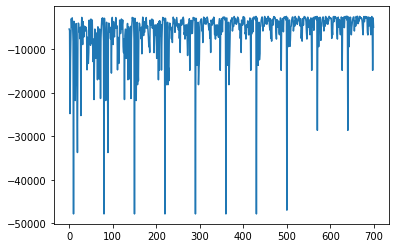

In [12]:
# get MCMC chains
sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[-1]
print("(num samples, num params) :", samples_mcmc.shape)

walker_ratio = fitting_list[0][1]['walkerRatio']
num_param_nonlinear = len(param_mcmc)

plt.plot(dist_mcmc)
plt.show()

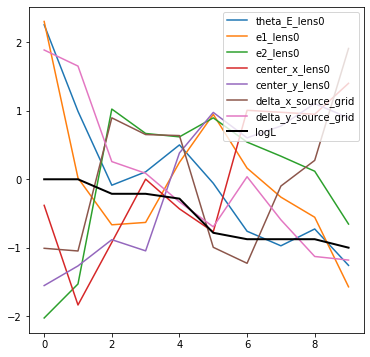

In [13]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i, num_average=walker_ratio*num_param_nonlinear)
plt.show()

In [14]:
# best fit from MCMC
kwargs_result = fitting_seq.best_fit()
print(kwargs_result)

{'kwargs_lens': [{'theta_E': 1.0015716435338133, 'e1': -0.08787281400400192, 'e2': 0.0942697013295496, 'center_x': 0.012464428003621516, 'center_y': 0.057050778124490345}], 'kwargs_source': [{'coeffs': 1, 'n_scales': 6, 'n_pixels': 4761}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {'delta_x_source_grid': 0.0020852509829241365, 'delta_y_source_grid': 0.0020567749699190356}, 'kwargs_extinction': []}


truth [1, -0.1, 0.1, 0.02, 0.05, 0, 0]


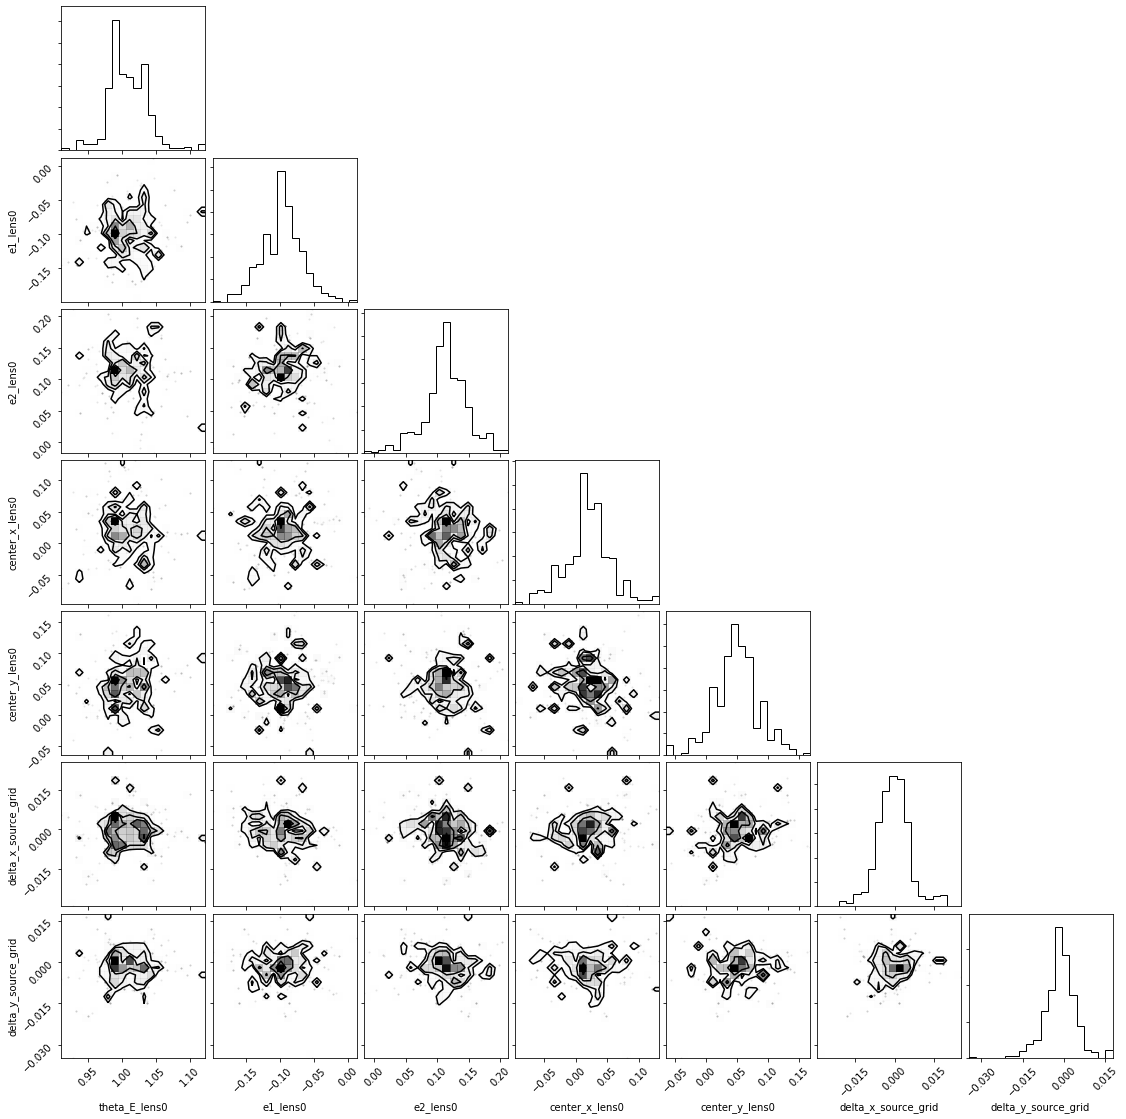

In [15]:
# get true parameter values as list
truth_params = fitting_seq.param_class.kwargs2args(**kwargs_truth)
print("truth", truth_params)

fig = corner.corner(samples_mcmc, labels=param_mcmc, truth=truth_params)
plt.show()

theta_E_lens0 1.0004 +/- 0.0178
e1_lens0 -0.0960 +/- 0.0184
e2_lens0 0.1088 +/- 0.0169
center_x_lens0 0.0196 +/- 0.0207
center_y_lens0 0.0510 +/- 0.0229
delta_x_source_grid -0.0003 +/- 0.0041
delta_y_source_grid -0.0018 +/- 0.0038


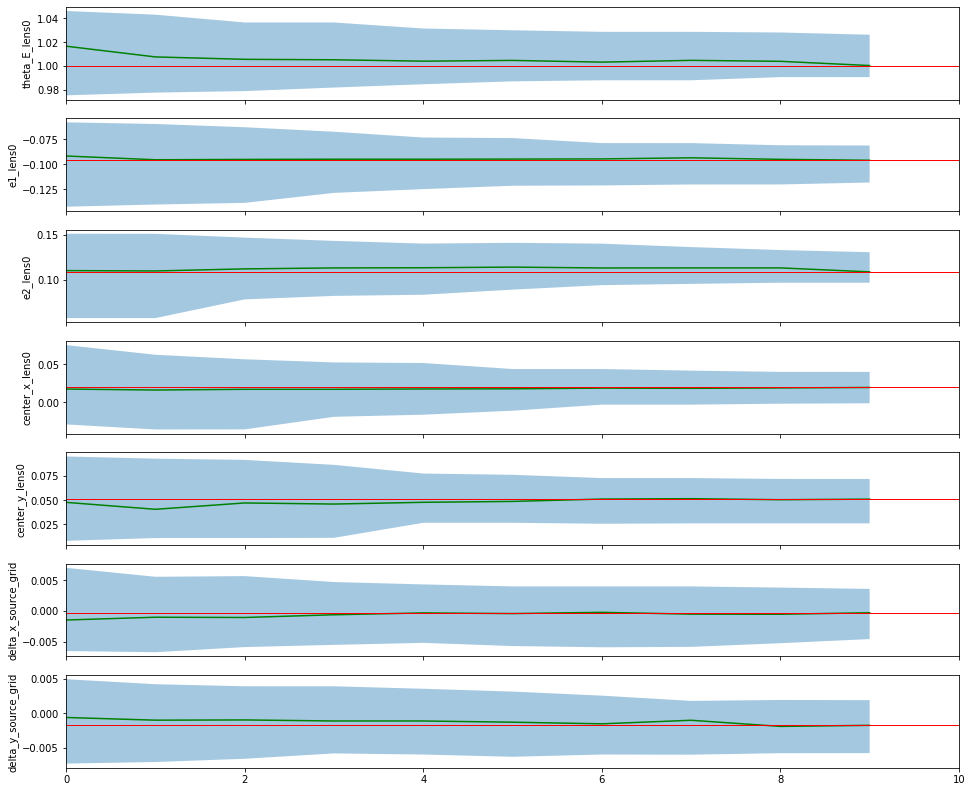

In [16]:
# convergence by walkers
[fig] = plot_convergence_by_walker(samples_mcmc, param_mcmc, walker_ratio, verbose=True)
plt.show()

### Update Starlets parameters from best fit

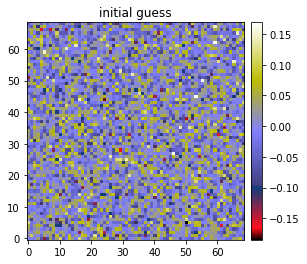

{'kwargs_lens': [{'theta_E': 1.0015716435338133, 'e1': -0.08787281400400192, 'e2': 0.0942697013295496, 'center_x': 0.012464428003621516, 'center_y': 0.057050778124490345}], 'kwargs_source': [{'coeffs': array([0.        , 0.        , 0.        , ..., 0.00994453, 0.00912461,
       0.00834795]), 'n_scales': 6, 'n_pixels': 4761, 'scale': 0.07999999999999999}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {'delta_x_source_grid': 0.0020852509829241365, 'delta_y_source_grid': 0.0020567749699190356}, 'kwargs_extinction': []} (28566,)


In [17]:
multi_band_list = kwargs_data_joint['multi_band_list']
multi_band_type = kwargs_data_joint['multi_band_type']
likelihood_mask_list = kwargs_likelihood.get('image_likelihood_mask_list', None)
kwargs_sparse_solver = kwargs_likelihood['kwargs_sparse_solver']
im_sim = class_creator.create_im_sim(multi_band_list, multi_band_type, kwargs_model,
                                     likelihood_mask_list=likelihood_mask_list,
                                     kwargs_sparse_solver=kwargs_sparse_solver)

# compute starlets "sparse" parameters and update corresponding kwargs
model, model_error = im_sim.image_sparse_solve(**kwargs_result)
print(kwargs_result, kwargs_result['kwargs_source'][0]['coeffs'].shape)

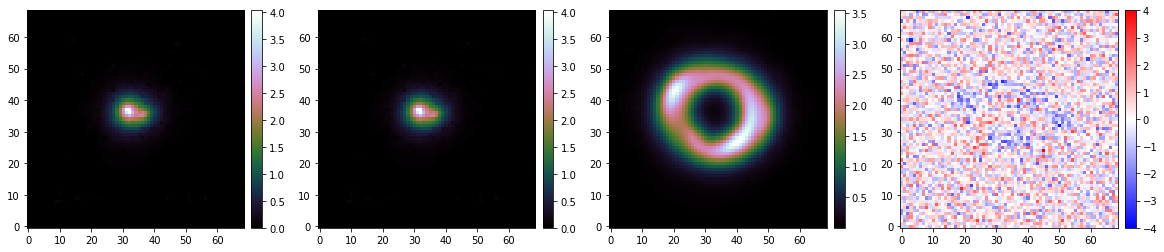

In [18]:
reduced_residuals  = im_sim.reduced_residuals(model)
source = im_sim.source_surface_brightness(kwargs_result['kwargs_source'], kwargs_lens=None, 
                                          unconvolved=True, de_lensed=True)

kwargs_source_result = kwargs_result['kwargs_source'][0]
starlets_class = Starlets(second_gen=False)
x_grid_hd, y_grid_hd = lenstro_util.make_grid(numPix=np.sqrt(kwargs_source_result['n_pixels']), 
                                              deltapix=kwargs_source_result['scale'])
source_hd = lenstro_util.array2image(starlets_class.function(x_grid_hd, y_grid_hd, 
                                                             **kwargs_source_result))

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
ax = axes[0]
im = ax.imshow(source, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[1]
im = ax.imshow(source_hd, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[2]
im = ax.imshow(model, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[3]
im = ax.imshow(reduced_residuals, origin='lower', cmap='bwr', vmin=-4, vmax=4)
nice_colorbar(im)
#plt.show()
fig.savefig("last_starlets_recon.png")